In [1]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
from modules.utils import *
import numpy as np
import argparse
import imutils
import cv2

In [2]:
# define the answer key which maps the question number to the correct answer
ANSWER_KEY = {0: 1, 1: 4, 2: 0, 3: 3, 4: 1}

In [3]:
# load the image, convert it to grayscale, blur it slightly, then find edges
image = cv2.imread("../Data set/bubble sheet/test_case_2.png")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 75, 200)

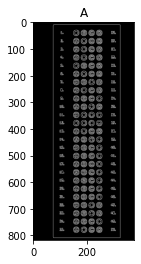

In [4]:
# show_images([image, gray, blurred, edged], ["image", "gray", "blurred", "edged"]);
show_images([edged], "After Edge Detection");

In [5]:
# find contours in the edged image 
contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

# initialize the contour that corresponds to the document
docCnt = None

# ensure that at least one contour was found
if len(contours) > 0:
    # sort the contours according to their size in descending order
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    # loop over the sorted contours
    for cnt in contours:
        # approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        # if our approximated contour has four points, then we sucessfully found the paper
        if len(approx) == 4:
            docCnt = approx
            break

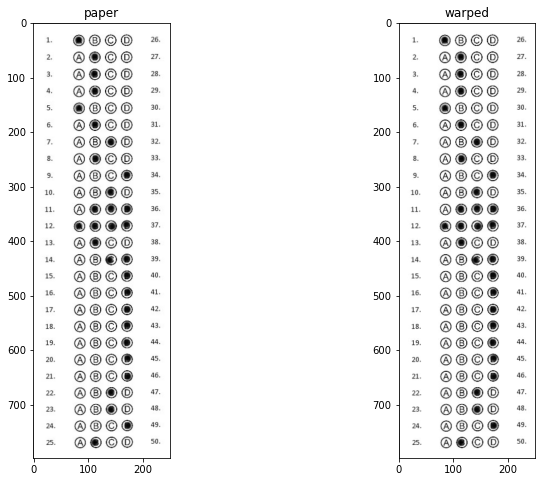

In [6]:
# apply a four point perspective transform to both the original image and grayscale image to obtain a top-down
# birds eye view of the paper
paper = four_point_transform(image, docCnt.reshape(4, 2))
warped = four_point_transform(gray, docCnt.reshape(4, 2))

show_images([paper, warped], ["paper", "warped"]);

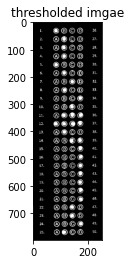

In [7]:
# apply Otsu's thresholding method to binarize the warped piece of paper
thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
show_images([thresh], ["thresholded imgae"]);

In [ ]:

# find contours in the thresholded image, then 
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)

# initialize the list of contours that correspond to questions/bubbles
questionCnts = []

# loop over the contours
for cnt in contours:
    # compute the bounding box of the contour, then use the bounding box to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(cnt)
    ar = w / float(h)
    # in order to label the contour as a question, region should be sufficiently wide, sufficiently tall, and
    # have an aspect ratio approximately equal to 1
    if w >= 20 and h >= 20 and ar >= 0.9 and ar <= 1.1:
        questionCnts.append(cnt)

# showin the controuse of bubbles on the image
cv2.drawContours(paper, questionCnts, -1, (255, 0, 0), 2)
cv2.imshow("Image with contours on bubbles", paper)
cv2.waitKey(0);
cv2.destroyAllWindows();